In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL #pillow to handle images
import tensorflow as tf

2023-02-28 00:09:01.488325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 00:09:02.687513: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-28 00:09:02.708345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 00:09:02.708385: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz" #tgz = tar ball (just like zip file)
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

In [3]:
valid_size = .2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import time

In [5]:
# Normalize the test and train sets with torchvision
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                       mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                          ])

In [6]:
NUM_EPOCHS = 10
lr = 0.001
batch_size = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
DEVICE

device(type='cpu')

In [8]:
# ImageFolder class to load the train and test images
train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir, transform=valid_transforms)

In [9]:
# Number of train images
num_train = len(train_data)
indices = list(range(num_train))

In [10]:
# Split = 20% of train images
split = int(np.floor(valid_size * num_train))
# Shuffle indices of train images
np.random.shuffle(indices)

In [11]:
# Subset indices for test and train
train_idx, valid_idx = indices[split:], indices[:split]

In [12]:
# Samples elements randomly from a given list of indices
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [13]:
# Batch and load the images
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

In [15]:
examples = iter(train_loader)
samples ,labels = next(examples)
samples.shape

torch.Size([32, 3, 224, 224])

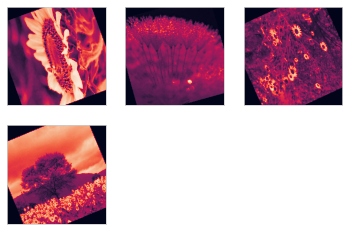

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
for i in range(4):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(samples[i][0])
plt.show()

In [17]:
def imshow(img,title):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(title)
    plt.show()

In [18]:
sample = samples[:4]
label = labels[:4]
out = torchvision.utils.make_grid(sample)

In [19]:
class_name = train_data.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


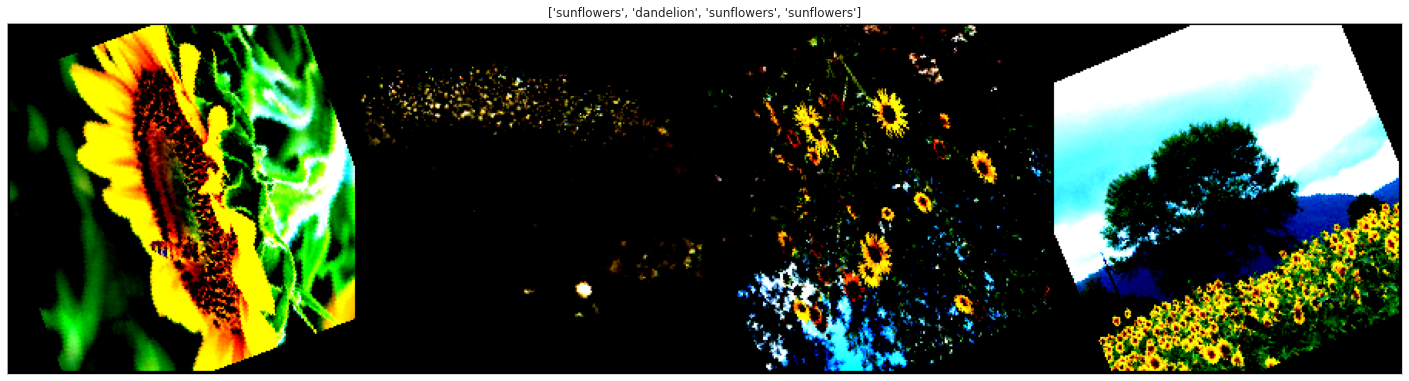

In [20]:
imshow(out,title=[class_name[x] for x in label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


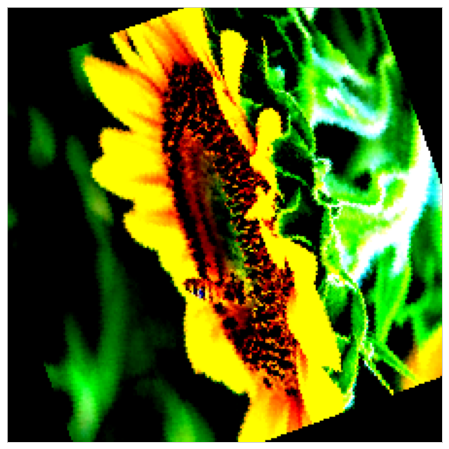

In [21]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.title(title)
    plt.show()
imshow(samples[0])

In [22]:
model = nn.Sequential(nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
                     nn.ReLU(),
                     nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
                     nn.ReLU(),
                     nn.MaxPool2d(2,2),
                     nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                     nn.ReLU(),
                     nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
                     nn.ReLU(),
                     nn.MaxPool2d(2,2),
                     nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
                     nn.ReLU(),
                     nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
                     nn.ReLU(),
                     nn.MaxPool2d(2,2),
                     nn.Flatten(),
                     nn.Linear(256*28*28,512),
                     nn.ReLU(),
                     nn.Linear(512,256),
                     nn.ReLU(),
                     nn.Linear(256,5))

In [23]:
model = model.to(DEVICE)

In [24]:
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        probas = model(features)
        cost = F.cross_entropy(probas, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 4:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        valid_acc = compute_accuracy(model, valid_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/010 | Batch 000/092 | Cost: 1.6105
Epoch: 001/010 | Batch 004/092 | Cost: 1.6160
Epoch: 001/010 | Batch 008/092 | Cost: 1.6144
Epoch: 001/010 | Batch 012/092 | Cost: 1.6214
Epoch: 001/010 | Batch 016/092 | Cost: 1.6350
Epoch: 001/010 | Batch 020/092 | Cost: 1.6516
Epoch: 001/010 | Batch 024/092 | Cost: 1.5941
Epoch: 001/010 | Batch 028/092 | Cost: 1.5973
Epoch: 001/010 | Batch 032/092 | Cost: 1.6268
Epoch: 001/010 | Batch 036/092 | Cost: 1.6341
Epoch: 001/010 | Batch 040/092 | Cost: 1.5978
Epoch: 001/010 | Batch 044/092 | Cost: 1.6916
Epoch: 001/010 | Batch 048/092 | Cost: 1.5169
Epoch: 001/010 | Batch 052/092 | Cost: 1.5768
Epoch: 001/010 | Batch 056/092 | Cost: 1.7743
Epoch: 001/010 | Batch 060/092 | Cost: 1.5448
Epoch: 001/010 | Batch 064/092 | Cost: 1.5416
